# Non-stationary [SCM-MAB](https://papers.nips.cc/paper/2018/hash/c0a271bc0ecb776a094786474322cb82-Abstract.html)

- Need to allow for prior on causal effects (--> Bayesian MAB)
- Non-stationary Bayesian structural causal MAB
    - Non-stationary because the reward statistics changes across time
    - Bayesian because we have a prior on the reward distribution
    - Structural because we are aware of the causal structure of the reward distribution 

## Stationarity assumptions of standard MAB algorithms

- Thompson Sampling (Thompson, 1933), UCB and epsilon-greedy assume that the rewards are i.i.d. samples from stationary distributions (Allesiardo et al., 2017), thus are not suitable for the (DBN-like underyling CGM) application.
- The EXP3 (Auer et al., 2002b) MAB algorithm makes comparatively fewer assumptions on reward distributions and can deal with the general setting of adversarially-defined rewards. The general adversarial bandit setting is important for our application as it enables the MAB to handle the non-stationary nature of the rewards observed during the optimisation (Allesiardo et al., 2017).

## Considerations

- Appears to be a so-called 'restless bandit problem'
- _Sometimes_ we have observational data, so we have a strong prior on the reward distribution
- We are doing inference on the reward distribution (exploring it) whilst playing the game, this means we are dealing with NS-MAB.
- At the start of the game, all we have is a prior on the reward distribution (one for each exploration set) but as we play the game, we collect more observations, update our prior, and then continue the game until we find the best arm. 
    - **CONTINUOUS CAUSAL EFFECTS** As we play the game, BO will tell us _where_ on the selected arm to explore

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../src")

In [2]:
from src.utils.dag_utils.graph_functions import make_graphical_model, make_networkx_object, get_time_slice_sub_graphs, make_time_slice_causal_diagrams

In [3]:
from npsem.utils import subseq
from npsem.NIPS2018POMIS_exp.scm_examples import IV_SCM
from npsem.scm_bandits import arms_of 
from npsem.bandits import play_bandits
from itertools import product

In [4]:
from src.examples.example_setup import setup_DynamicIVCD
from nsscmmab import NSSCMMAB
from collections import defaultdict
from npsem.model import default_P_U

In [5]:
from scipy.stats import bernoulli as ber
from src.utils.sampling import sample_sem
from src.examples.SEMs import testSEM
from src.utils.plotting import plot_binary_var_across_time

# Non-stationary SCM-MAB as piece-wise stationary SCM-MAB 

SCM-MAB will be run on the DAG in each time-slice (which could change across time). The reward distribution will change as we step through the graph, from left to right.

- We start with a DAG in which the connectivity is the same across time and then add complexity when it works.

In [4]:
node_info = {"Z": {"type": "manipulative", "domain": (0,1)},
             "X": {"type": "manipulative", "domain": (0,1)},
             "Y": {"type": "manipulative", "domain": (-1,1)}}
            #  "U" : {"type": "confounder"}}
# Constructor for adding unobserved confounder to graph
# XXX: this construction allows us to model situations in which confounding varibles appear and disappear across time-steps
conf_info = {0: ("X","Y"), 1:  ("X","Y"), 2:  ("X","Y")}

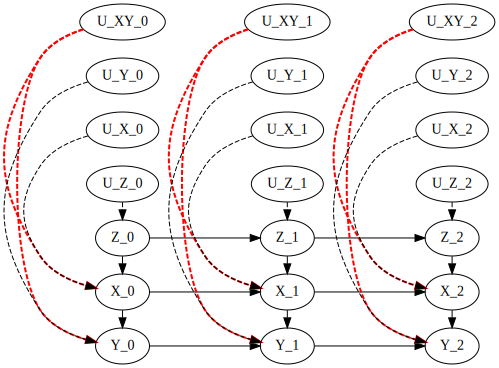

In [5]:
T = 3
graph_view = make_graphical_model(0,
T-1,
topology='dependent',
target_node='Y',
node_information= node_info,
confounder_info=conf_info,
verbose=True)
graph_view

In [6]:
background_info = {
    # Exogenous / background conditions
    "U_Z": {"type": "background", "domain": (0, 1)},
    "U_X": {"type": "background", "domain": (0, 1)},
    "U_Y": {"type": "background", "domain": (0, 1)},
    "U_XY": {"type": "confounder", "domain": (0, 1)},
}
# Contains all the sub-graphs per time-slice
G = make_networkx_object(graph_view, node_info | background_info, T)
# TODO: need to add assigned variable edges here but make sure that they are removed from the relevant node if that variable is intervened upon.
gs = get_time_slice_sub_graphs(G,T)
cds = make_time_slice_causal_diagrams(gs,conf_info)

## Explore SCM from fig 3

In [22]:
SEM = DynamicIVCD()
static = SEM.static()
dynamic = SEM.dynamic()

# SEM = DynamicIVCD()
# static = SEM.static()
# dynamic = SEM.dynamic(clamped={"X":0, 'Z':1, "Y":1})
T = 3
N = 10
exo_vars = {"U_Z": ber.rvs(p=0.6, size=(N,T)), "U_X":ber.rvs(p=0.11, size=(N,T)), "U_Y":ber.rvs(p=0.15, size=(N,T)) ,"U_XY":ber.rvs(p=0.51, size=(N,T))}
# epsilon = np.random.randint(2, size=(N,T))
# sem_samples  = {k:np.empty((N,T), dtype='int') for k in static.keys()}
# samples = sem_samples | exo_vars
# samples

In [6]:
from npsem.scm_bandits import SCM_to_bandit_machine, new_SCM_to_bandit_machine
from npsem.model import StructuralCausalModel
params = setup_DynamicIVCD()
m = NSSCMMAB(**params)
# s = sample_sem(DynamicIVCD,params['mu1'],T,N,0)
# Get target for this time index
temporal_index = 0
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)
print(m.arm_strategy)

#  Convert time-slice SCM to bandit machine
mu, arm_setting = SCM_to_bandit_machine(scm, target_variable=target_var_only)
#  Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

POMIS
(0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [30]:
temporal_index = 1
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.6610000000000003, 0.5490000000000003, 0.5546000000000002, 0.6610000000000003, 0.5518000000000002, 0.5490000000000003, 0.5490000000000003, 0.5546000000000002, 0.5546000000000002) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [31]:
temporal_index = 2
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}, {"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.6485555555555558, 0.5863333333333336, 0.5894444444444447, 0.6485555555555558, 0.5878888888888891, 0.5863333333333336, 0.5863333333333336, 0.5894444444444447, 0.5894444444444447) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


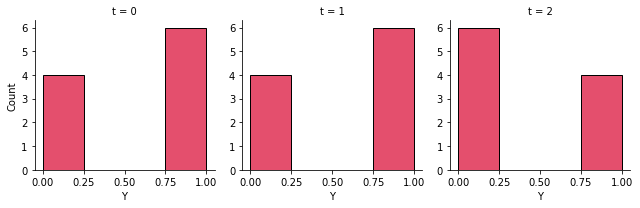

In [89]:
plot_binary_var_across_time(s,'Y')

# Test Non-Stationary (piece-wise stationary) SCM-MAB

In [81]:
from numpy import vectorize
import numpy as np
import multiprocessing
from npsem.NIPS2018POMIS_exp.test_bandit_strategies import load_result, compute_cumulative_regret, compute_optimality
from npsem.utils import with_default
from npsem.viz_util import sparse_index
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.plotting import set_size

In [115]:
def main_experiment_ccb(M: StructuralCausalModel, Y, past_interventions=None, num_trial=200, horizon=10000, n_jobs=1):
    results = dict()
    mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
    arm_strategy = 'POMIS'
    arm_selected = arms_of(arm_strategy, arm_setting, M.G, Y)
    arm_corrector = vectorize(lambda x: arm_selected[x])
    for bandit_algo in ["TS", "UCB"]:
        arm_played, rewards = play_bandits(horizon, subseq(mu, arm_selected), bandit_algo, num_trial, n_jobs)
        results[(arm_strategy, bandit_algo)] = arm_corrector(arm_played), rewards

    return results, mu

temporal_index = 1
target = 'Y_1'
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index

# SEM
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}]
num_simulation_repeats = 100
horizon=5000
results, mu = main_experiment_ccb(
    scm, target_var_only, past_interventions, num_simulation_repeats, horizon, n_jobs=3 * multiprocessing.cpu_count() // 2
)

In [117]:
num_simulation_repeats = 100
horizon=5000
results_scmmab, mu_scmmab = main_experiment_ccb(
    scm, target_var_only, None, num_simulation_repeats, horizon, n_jobs=3 * multiprocessing.cpu_count() // 2
)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done  11 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done  15 tasks      | elapsed:  

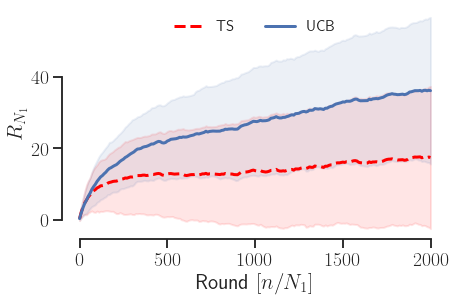

In [125]:
mu_star = max(mu_scmmab)
out_scmmab = {'TS':None, 'UCB':None}
for pi in ['TS', 'UCB']:
    value_matrix = compute_cumulative_regret(results_scmmab[('POMIS', pi)][1], mu_star, remove_negative_cr=False)

    mean_x = np.mean(value_matrix, axis=0)
    sd_x = np.std(value_matrix, axis=0)
    lower, upper = mean_x - sd_x, mean_x + sd_x
    cut_time = 2000
    time_points = sparse_index(with_default(cut_time, len(mean_x)), 200)
    out_scmmab[pi] = [time_points, mean_x, lower, upper]

plot_CR(out_scmmab, 'scmmab')

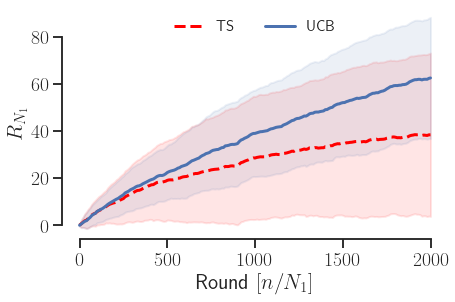

In [126]:
mu_star = max(mu)
out = {'TS':None, 'UCB':None}
for pi in ['TS', 'UCB']:
    value_matrix = compute_cumulative_regret(results[('POMIS', pi)][1], mu_star, remove_negative_cr=False)

    mean_x = np.mean(value_matrix, axis=0)
    sd_x = np.std(value_matrix, axis=0)
    lower, upper = mean_x - sd_x, mean_x + sd_x
    cut_time = 2000
    time_points = sparse_index(with_default(cut_time, len(mean_x)), 200)
    out[pi] = [time_points, mean_x, lower, upper]

plot_CR(out, 'ccb')